### Set the run number here; decides which directory to save model and results - should match the number on the corresponding yaml file for the model run

In [1]:
run_num = 8

In [2]:
%reload_ext autoreload
import os
curr_dir = "/home/mushaikh/private/PointCloudPosePrediction"
# curr_dir = "/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction"
os.chdir(curr_dir)
import importlib
import time
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import open3d as o3d
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from typing import Any, Callable, Optional, Tuple
import yaml
import cv2
import matplotlib.pyplot as plt
import core.pointnet as pnet
import core.deep_pose_estimator as dpe
import core.loss as dpe_loss
import utils.dataloader
import utils.utils
import utils.vision
importlib.reload(dpe)
importlib.reload(pnet)
importlib.reload(utils.utils)
importlib.reload(utils.vision)
importlib.reload(utils.dataloader)

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<module 'utils.dataloader' from '/home/mushaikh/private/PointCloudPosePrediction/utils/dataloader.py'>

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

cuda


In [4]:
# load params for current model run; choose model run below after creating yaml file for it
with open("./models/run_{x}/run_{x}.yaml".format(x=run_num)) as f:
    params = yaml.safe_load(f)

In [5]:
# create data loader for Eden data - outputs pairs of point clouds and relative poses
batch_size = params['train']['batch_size']
# "/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample"
dataset = utils.dataloader.EdenDataset("/home/mushaikh/private/sample",
                                            keypt_method=params['keypoint_detection']['detection_method'],
                                            pcd_num_pts = params['keypoint_detection']['pcd_num_pts']
                                            )

train_inds, val_inds = torch.utils.data.random_split(dataset, [0.8,0.2])

train_sampler = torch.utils.data.SubsetRandomSampler(train_inds.indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_inds.indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [6]:
"loss_scale" in params['train']

True

Epoch 0


100%|██████████| 60/60 [04:52<00:00,  4.88s/it]


Avg. train loss: 647.048428
Avg. validation loss: 510.4978393554687
Epoch 1


100%|██████████| 60/60 [04:49<00:00,  4.83s/it]


Avg. train loss: 557.987056
Avg. validation loss: 569.505196126302
Epoch 2


100%|██████████| 60/60 [04:36<00:00,  4.62s/it]


Avg. train loss: 575.133045
Avg. validation loss: 524.6267354329427
Epoch 3


100%|██████████| 60/60 [04:24<00:00,  4.42s/it]


Avg. train loss: 552.751264
Avg. validation loss: 512.6148885091146
Epoch 4


100%|██████████| 60/60 [04:29<00:00,  4.49s/it]


Avg. train loss: 524.206469
Avg. validation loss: 507.7080078125
Epoch 5


100%|██████████| 60/60 [04:27<00:00,  4.46s/it]


Avg. train loss: 511.039108
Avg. validation loss: 504.63311971028645
Epoch 6


100%|██████████| 60/60 [04:28<00:00,  4.47s/it]


Avg. train loss: 508.282912
Avg. validation loss: 498.2577412923177
Epoch 7


100%|██████████| 60/60 [04:31<00:00,  4.52s/it]


Avg. train loss: 487.770901
Avg. validation loss: 488.3349853515625
Epoch 8


100%|██████████| 60/60 [04:31<00:00,  4.53s/it]


Avg. train loss: 492.393241
Avg. validation loss: 484.68951009114585
Epoch 9


100%|██████████| 60/60 [04:37<00:00,  4.63s/it]


Avg. train loss: 478.902283
Avg. validation loss: 485.1752502441406


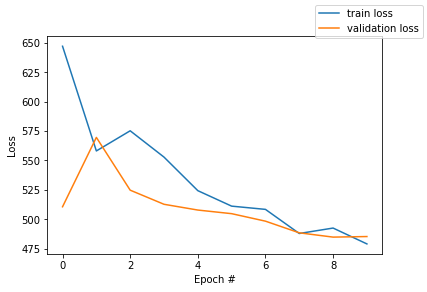

In [7]:
# training loop

model = dpe.DeepPoseEstimator(num_pts=params['keypoint_detection']['pcd_num_pts'], 
                              use_pca = params['model']['use_pca'])
model.to(device)

lr = params['train']['lr']
# scale loss to make values larger to assist training - backward compatible for 
# configs from before param was introduced
loss_scale = params['train']['loss_scale'] if "loss_scale" in params["train"] else 1
grad_accum_steps = params['train']['grad_accum_steps'] if "grad_accum_steps" in params["train"] else 1

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

list_train_loss = []
list_val_loss = []

for epoch in range(params['train']['epochs']):
    print("Epoch {}".format(epoch))
    running_train_loss = 0
    
    for i, data in enumerate(tqdm(train_loader)):
        
        # prepare data
        pcd1, pcd2, quat, translation = data["pcd1"], data["pcd2"], data["quat"], data["translation"]
        pcd1, pcd2 = pcd1.permute(0,2,1), pcd2.permute(0,2,1)
        target = torch.cat((translation.transpose(1,0), quat.transpose(1,0))).transpose(1,0)
        
        # move to gpu
        pcd1, pcd2, quat, translation, target = pcd1.to(device), pcd2.to(device), quat.to(device), translation.to(device), target.to(device)
        
        # set mode to train - sets batchnorm/dropout policy etc.
        model.train()
        
        # get preds from model
        pred, trans_feat_1, trans_feat_2 = model(pcd1, pcd2) # predicts 7-length vector of translation/quaternion
        
        # compute loss
        loss = loss_scale * (dpe_loss.PoseLoss(pred, target) + \
            pnet.feature_transform_regularizer(trans_feat_1) * 0.001 + \
                pnet.feature_transform_regularizer(trans_feat_1) * 0.001)
        
        # backward pass
        loss.backward()
        
        running_train_loss += loss.item()

        if i % grad_accum_steps == 0:
            # gradient descent step 
            optimizer.step()
            # reset gradients
            optimizer.zero_grad()
    
    avg_train_loss = running_train_loss / (i + 1)
    print('Avg. train loss: %f' % (avg_train_loss))
    list_train_loss.append(avg_train_loss)
    
    # update the learning rate scheduler
    scheduler.step()
    
    # check validation loss after every epoch
    
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization
    model.eval()
    running_vloss = 0.0
    
    # Disable gradient computation and reduce memory consumption
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            pcd1, pcd2, quat, translation = vdata["pcd1"], vdata["pcd2"], vdata["quat"], vdata["translation"]
            pcd1, pcd2 = pcd1.permute(0,2,1), pcd2.permute(0,2,1)
            target = torch.cat((translation.transpose(1,0), quat.transpose(1,0))).transpose(1,0)
            pcd1, pcd2, quat, translation, target = pcd1.to(device), pcd2.to(device), quat.to(device), translation.to(device), target.to(device)
            pred, trans_feat_1, trans_feat_2 = model(pcd1, pcd2)
            vloss = loss_scale * (dpe_loss.PoseLoss(pred, target) + \
                pnet.feature_transform_regularizer(trans_feat_1) * 0.001 + \
                pnet.feature_transform_regularizer(trans_feat_1) * 0.001)
            running_vloss += vloss.item()
            
    avg_vloss = running_vloss / (i + 1)
    print('Avg. validation loss: {}'.format(avg_vloss))
    list_val_loss.append(avg_vloss)
    
    # save the model after every epoch
    torch.save(model.state_dict(), '{y}/run_{x}/run_{x}_deep_pose_{z}.pth'.format(
        x=run_num, y=os.path.join(curr_dir,"models"), z=epoch))


# plot the loss curves
fig, ax = plt.subplots(1,1)
ax.plot(range(params['train']['epochs']), list_train_loss, label="train loss")
ax.plot(range(params['train']['epochs']), list_val_loss, label="validation loss")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss")
fig.legend()
fig.savefig(os.path.join(curr_dir,"results","run_{x}_loss.png".format(x=run_num)))